# Function for Basic Linear Regression on Cluster Plot
## Example Parameter: Avg Leaf Nitrogen Concentration (LNC) vs Leaf Carbon Nitrogen Ratio (LCN)
#### Author: Sofia Ingersoll

##### Loading environment settings

In [1]:
# moved the libraries that were here into utils.py because they're essential
# xarray is required to run the utils import line
import xarray as xr
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

Calling the machine learning utils.py `ml_utils.py` located in this ML folder

In [2]:
# import libraries & data pre-processing functions from utils.py
from ml_utils import *

### Leaf Carbon : Nitrogen Data 

**At this point in time, I am unable to plot this data because it contains NaN**

This will come in handy later when we want to plot trends overtime.


In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----     load data stored in casper     ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#-------Dummy Variable Data---------
#-------Leaf Carbon : Nitrogen Data---------
# x variable data for plotting
df = pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt',index_col=0)
# convert to data set
params = xr.Dataset(df)

# the only dimension here is the 'member' aka file index id [LCH0001-500]
params

# subsetting for leafcn
leafcn = params['leafcn']

##### Request additional processing power from server

In [4]:
# Request an additional 10 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 40)

In [5]:
# apply peer2peer network communication across multiple devices
client.cluster

PBSCluster(c88ffb23, 'tcp://128.117.208.109:45973', workers=4, threads=4, memory=37.24 GiB)

## Loading a Cluster of 500 files
The data files are located in `/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/`

The 2005-2010 monthly output files have the form:
`PPEn11_transient_LHC0001.clm2.h0.2005-02-01-00000.nc`

We're interested in files spanning from:
`LHC0001 to LHC0500`

In [6]:
da = read_all_simulations('LNC')

## Wrangling Cluster for Global Avg with properly weighted dimensions (time & gridcell) 

Leaf Carbon to Nitrogen Ratio Read & Wrangle

### Applying data processing functions from utils
At this point in time, only the `fix_time()` function may be successfully applied to the cluster ensemble.

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----   parameter wrangling    ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# apply the bug fixing & dim. reduction functions 

# feb. ncar time bug
da = fix_time(da)

# convert xr.ds to xr.da
da = da['LNC']

# weight gridcell dim by global land area
da_global = weight_landarea_gridcells(da,landarea)

# weight time dim by days in month
da_global_ann = yearly_weighted_average(da_global)

# take global avg for param over year dimension
lnc = da_global_ann.mean(dim='year')

In [8]:
lnc

<xarray.DataArray (ens: 500)>
dask.array<mean_agg-aggregate, shape=(500,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Dimensions without coordinates: ens

### Visualize Cluster Plot with Linear Regression
I confirmed that the leafcn data provided and LNC are the same length, but it's not running. I am going to create a data array from the cluster files read in 

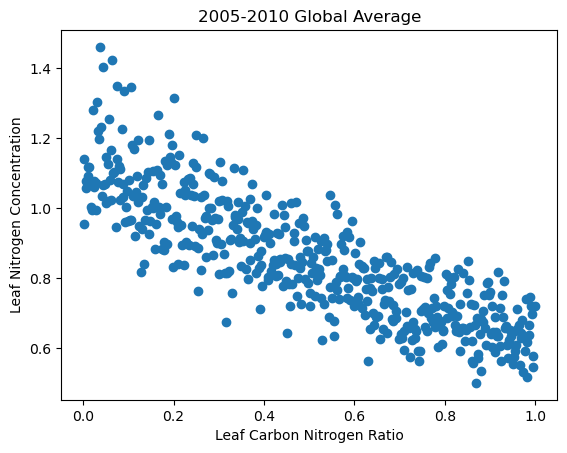

In [9]:
plt.scatter(x = leafcn,
            y = lnc)

# Set plot labels and title
plt.xlabel('Leaf Carbon Nitrogen Ratio')
plt.ylabel('Leaf Nitrogen Concentration')
plt.title('2005-2010 Global Average')

# Show the plot
plt.show()

### Functions

#### Function for user selected variable & parameter subsetting, wrangling, & plotting
Here we can see greater definition regarding the shape of the points. There seems to be less of a linear relationship than the one observed above. However, the x-axis is not wihtin hte same bounds and this is concerning.

Also, need to create a list of nicely written parameter and variable names to call from for an f str in the x & y labels.

In [18]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----    User Selected Plotting Funct    ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def subset_and_plot_cluster(var, parameter):
    '''describe the relationship between the selected variable 
    and parameter(s) between 2005-2010. output a
    cluster plot averaged by year.'''
    
    # Read in and wrangle user selected parameter cluster
    da_p = read_all_simulations(parameter)

    # feb. ncar time bug
    da = fix_time(da_p)
    # convert xr.ds to xr.da
    da = da[parameter]
    # weight gridcell dim by global land area
    da_global = weight_landarea_gridcells(da, landarea)
    # weight time dim by days in month
    da_global_ann = yearly_weighted_average(da_global)
    # take global avg for param over year dimension
    param_avg = da_global_ann.mean(dim='year')

    # Read in and wrangle user selected variable cluster
    da_v = read_all_simulations(var)
    # feb. ncar time bug
    da = fix_time(da_v)
    # convert xr.ds to xr.da
    da = da[var]
    # weight gridcell dim by global land area
    da_global = weight_landarea_gridcells(da, landarea)
    # weight time dim by days in month
    da_global_ann = yearly_weighted_average(da_global)
    # take global avg for variable over year dimension
    var_avg = da_global_ann.mean(dim='year')

    # Plotting
    plt.scatter(x=var_avg, y=param_avg)
    # Set plot labels and title
    plt.xlabel(var)
    plt.ylabel(parameter)
    plt.title('2005-2010 Global Average')
    # Show the plot
    plt.show()

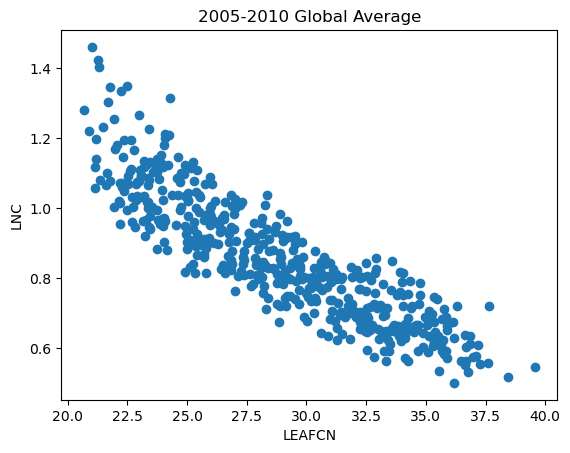

In [11]:
# Example usage:
subset_and_plot_cluster('LEAFCN', 'LNC')

#### Function including GPR line for plotting

Overfitting issue likely caused by simplistic relationship

In [14]:
def subset_and_plot_gpr(var, parameter):
    '''describe the relationship between the selected variable 
    and parameter(s) over the selected period of time. output a
    best fit line of regression.'''
    
    # Read in and wrangle user selected parameter cluster
    da_p = read_all_simulations(parameter)

    # feb. ncar time bug
    da = fix_time(da_p)
    # convert xr.ds to xr.da
    da = da[parameter]
    # weight gridcell dim by global land area
    da_global = weight_landarea_gridcells(da, landarea)
    # weight time dim by days in month
    da_global_ann = yearly_weighted_average(da_global)
    # take global avg for param over year dimension
    param_avg = da_global_ann.mean(dim='year')

    # Read in and wrangle user selected variable cluster
    da_v = read_all_simulations(var)
    # feb. ncar time bug
    da = fix_time(da_v)
    # convert xr.ds to xr.da
    da = da[var]
    # weight gridcell dim by global land area
    da_global = weight_landarea_gridcells(da, landarea)
    # weight time dim by days in month
    da_global_ann = yearly_weighted_average(da_global)
    # take global avg for variable over year dimension
    var_avg = da_global_ann.mean(dim='year')

    # Plotting
    plt.scatter(x=var_avg, y=param_avg)
    # Set plot labels and title
    plt.xlabel(var)
    plt.ylabel(parameter)
    plt.title('2005-2010 Global Average')

    # Set boundaries
    plt.xlim(0, 40)  # Adjusted boundary for Leaf Carbon Nitrogen Ratio
    plt.ylim(0, 1.5)  # Adjusted boundary for Leaf Nitrogen Concentration

    # Gaussian Process Regression
    kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    X = var_avg.values.reshape(-1, 1)
    y = param_avg.values
    gp.fit(X, y)
    x_pred = np.linspace(X.min(), X.max(), 1000)
    y_pred, sigma = gp.predict(x_pred[:, np.newaxis], return_std=True)
    plt.plot(x_pred, y_pred, 'r-', label='Gaussian Process Regression')
    plt.fill_between(x_pred, y_pred - sigma, y_pred + sigma, alpha=0.2, color='r')

    # Show legend
    plt.legend()

    # Show the plot
    plt.show()

/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


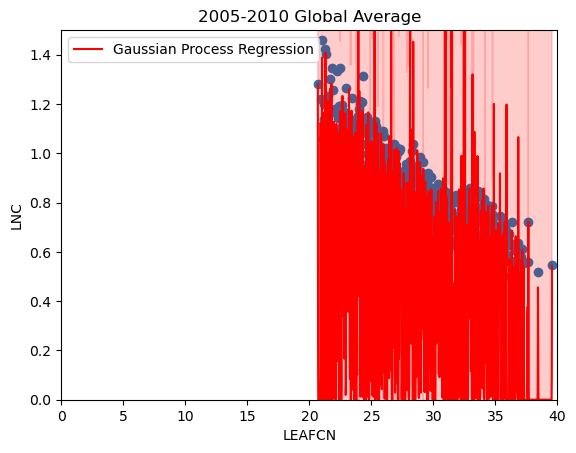

In [15]:
# Example usage:
subset_and_plot_gpr('LEAFCN', 'LNC')

An attempt to reduce overfitting issues

In [19]:
def subset_and_plot_gpr(var, parameter):
    '''describe the relationship between the selected variable 
    and parameter(s) over the selected period of time. output a
    best fit line of regression.'''
    
    # Read in and wrangle user selected parameter cluster
    da_p = read_all_simulations(parameter)

    # feb. ncar time bug
    da = fix_time(da_p)
    # convert xr.ds to xr.da
    da = da[parameter]
    # weight gridcell dim by global land area
    da_global = weight_landarea_gridcells(da, landarea)
    # weight time dim by days in month
    da_global_ann = yearly_weighted_average(da_global)
    # take global avg for param over year dimension
    param_avg = da_global_ann.mean(dim='year')

    # Read in and wrangle user selected variable cluster
    da_v = read_all_simulations(var)
    # feb. ncar time bug
    da = fix_time(da_v)
    # convert xr.ds to xr.da
    da = da[var]
    # weight gridcell dim by global land area
    da_global = weight_landarea_gridcells(da, landarea)
    # weight time dim by days in month
    da_global_ann = yearly_weighted_average(da_global)
    # take global avg for variable over year dimension
    var_avg = da_global_ann.mean(dim='year')

    # Plotting
    plt.scatter(x=var_avg, y=param_avg)
    # Set plot labels and title
    plt.xlabel(var)
    plt.ylabel(parameter)
    plt.title('2005-2010 Global Average')

    # Set boundaries
 #   plt.xlim(0, 100)  # Adjusted boundary for Leaf Carbon Nitrogen Ratio
 #   plt.ylim(0, 1.5)  # Adjusted boundary for Leaf Nitrogen Concentration

    # Gaussian Process Regression
    kernel = C(1.0, (1e-2, 1e2)) * RBF(1.0, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
    X = var_avg.values.reshape(-1, 1)
    y = param_avg.values
    gp.fit(X, y)
    x_pred = np.linspace(0, 40, 100).reshape(-1, 1)
    y_pred, sigma = gp.predict(x_pred, return_std=True)
    plt.plot(x_pred, y_pred, 'r-', label='Gaussian Process Regression')
    plt.fill_between(x_pred.flatten(), y_pred - sigma, y_pred + sigma, alpha=0.2, color='r')

    # Show legend with confidence interval
    plt.legend(loc='upper right', labels=['Data', 'Gaussian Process Regression', '95% Confidence Interval'])


    # Show the plot
    plt.show()

Adding 95% confidence interval label in legend and trying to correct for overfitting

/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


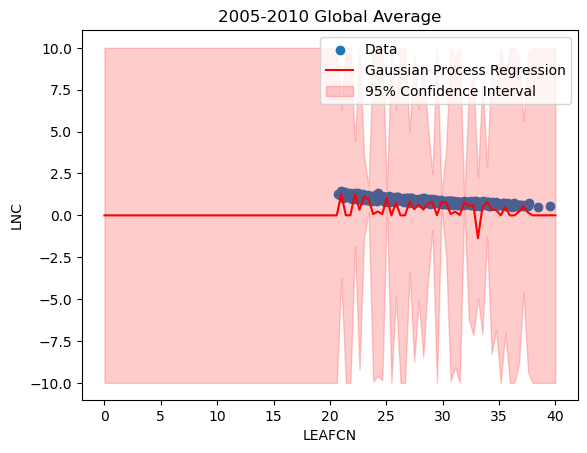

In [20]:
# Example usage:
subset_and_plot_gpr('LEAFCN', 'LNC')

/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


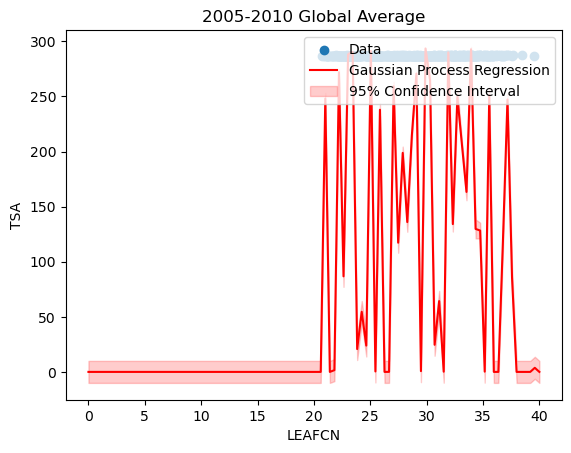

In [21]:
subset_and_plot_gpr('LEAFCN', 'TSA')

## Linear Regression


In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Split Data 90/10        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
x_train, x_test, y_train, y_test = train_test_split(leafcn, 
                                                    lnc, 
                                                    test_size = 0.20,
                                                    random_state=0)

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Linear Regression       ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
regressor = LinearRegression()
regressor.fit(leafcn, lnc)

In [ ]:
# Assuming leafcn_da and LNC_da are your pre-processed data arrays
# Make sure that leafcn_da and LNC_da have the same length and are 1D arrays
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Split Data 90/10        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
x_train, x_test, y_train, y_test = train_test_split(leafcn, lnc, test_size=0.1, random_state=0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Linear Regression       ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
regressor = LinearRegression()
regressor.fit(x_train, y_train)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----       Make Predictions       ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
y_pred = regressor.predict(x_test)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----    Plot Linear Regression    ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.scatter(x_train, y_train, color='g', label='Training Data')
plt.scatter(x_test, y_test_, color='b', label='Testing Data')
plt.plot(x_test, y_pred, color='k', linewidth=2, label='Linear Regression')

plt.xlabel('Leaf Carbon Nitrogen Ratio')
plt.ylabel('Leaf Nitrogen Concentration')
plt.title("Linear Regression of f{'var'} vs f{'param'}")
plt.legend()
plt.show()